In [22]:
import pandas as pd
import numpy as np
import datetime as dt
import json
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype

data_path = './transaction-data-adhoc-analysis.json'
df = pd.read_json(data_path)

df["transaction_items"] = df["transaction_items"].str.split(";")
df["Month"] = pd.to_datetime(df["transaction_date"]).dt.month

def month_name(x):
    month_names= {1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun"}
    return month_names[x]
df["Month"]= df["Month"].apply(month_name).astype(pd.CategoricalDtype(categories= ["Jan", "Feb", "Mar", "Apr", "May", "Jun"], ordered=True))
df.head()

,address,birthdate,mail,name,sex,username,transaction_items,transaction_value,transaction_date,Month
0,USNS Wagner\nFPO AE 00917,1926/03/11,watsonbrenda@gmail.com,Jennifer Campbell,F,veronicawells,"[Exotic Extras,Beef Chicharon,(x4)]",5196,2022/01/12,Jan
1,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,cgilbert,"[Exotic Extras,Beef Chicharon,(x3), HealthyKid...",12056,2022/01/12,Jan
2,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,cgilbert,"[HealthyKid 3+,Gummy Vitamins,(x3), HealthyKid...",5500,2022/01/08,Jan
3,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,cgilbert,"[HealthyKid 3+,Yummy Vegetables,(x1)]",500,2022/01/10,Jan
4,"33911 Hansen Loaf\nWest Sandra, ND 54188",1949/09/27,michael78@yahoo.com,Kristen Cooper,F,qhernandez,"[Candy City,Orange Beans,(x3), Candy City,Gumm...",2697,2022/01/24,Jan


In [3]:
pivot_table_1=pd.pivot_table(df, columns= "Month", values= "transaction_value", aggfunc= "sum")

#Total sales revenue per month
pivot_table_1.rename(index={"transaction_value": "Sales Revenue"})

Month,Jan,Feb,Mar,Apr,May,Jun
Sales Revenue,62522565,63820403,63943846,63420965,63740675,63704318


In [4]:
#Average transaction value of customers per month
pivot_table_2= pd.pivot_table(df,columns= "Month", values= "transaction_value", aggfunc= "mean")

#Average transaction value of customers per month
pivot_table_2.rename(index={"transaction_value": "Average Transaction Value"})

Month,Jan,Feb,Mar,Apr,May,Jun
Average Transaction Value,4567.691774,4567.735686,4599.614876,4602.72625,4597.567441,4605.908322


In [5]:
def age(x):
    return dt.date.today().year- int(x[0:4])

df["age"]= df["birthdate"].apply(age)

def organize(x):
    if x>= 94:
        return "Greatest Generation"
    if x<94  and x>= 76:
        return "Silent Generation"
    if x<76 and x>= 58:
        return "Baby Boomers"
    if x<58 and x>= 46:
        return "Gen X"
    if x<46 and x>= 25:
        return "Millenials"
    if x<25 and x>=12:
        return "Gen Z"
    else:
        return "Generation Alpha"

df["age"]= df["age"].apply(organize).astype(pd.CategoricalDtype(categories= ["Generation Alpha", "Gen Z", "Millenials", "Gen X", "Baby Boomers", "Silent Generation", "Greatest Generation"], ordered=True))

df["Generation"] = df["age"]

pivot_table_3= pd.pivot_table(df, index= "Month", columns= "Generation", values= "transaction_value", aggfunc= "mean")
pivot_table_3.rename(index={"transaction_value": "Average Transaction Value"})

age_count= df.loc[:,["Generation","Month"]].groupby(by="Generation", as_index =False).count().rename(columns={"Month":"Count"})
age_count

,Generation,Count
0,Generation Alpha,8437
1,Gen Z,9332
2,Millenials,14536
3,Gen X,8492
4,Baby Boomers,12430
5,Silent Generation,12871
6,Greatest Generation,16938


<AxesSubplot:ylabel='Count'>

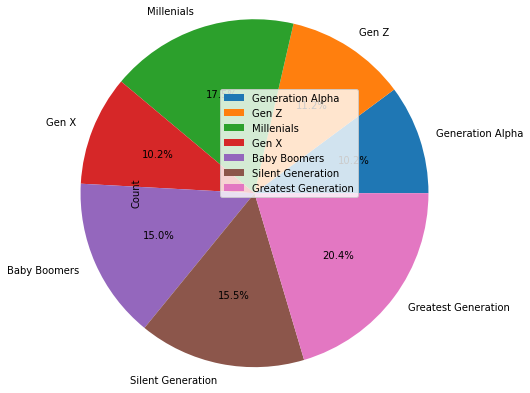

In [6]:
age_count.groupby(["Generation"]).sum().plot(kind='pie', y= "Count", radius= 2, autopct="%1.1f%%",)

Text(0.5, 1.0, 'Age Demographic')

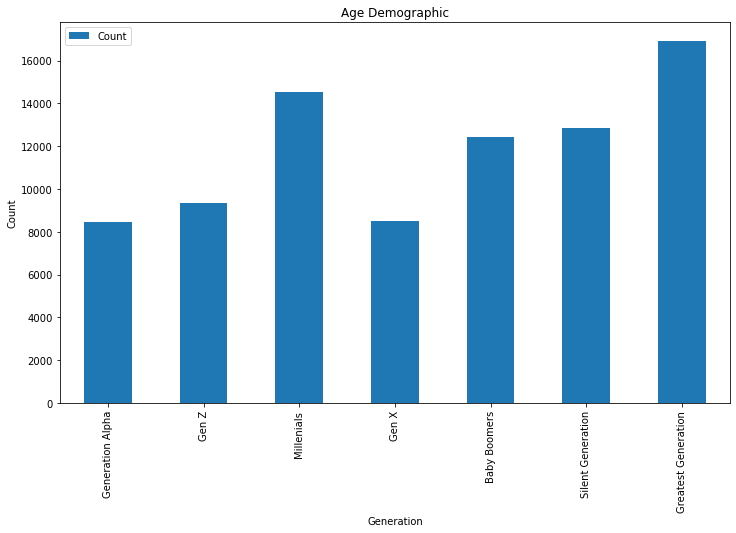

In [7]:
data= age_count.plot.bar(figsize=(12,7))
data.set_xticklabels(["Generation Alpha", "Gen Z", "Millenials", "Gen X", "Baby Boomers", "Silent Generation", "Greatest Generation"]) 
data.set_xlabel("Generation")
data.set_ylabel("Count")
data.set_title("Age Demographic")

In [8]:
pivot_table_4= pd.pivot_table(df,index= "Month", columns= "Generation", values= "transaction_value", aggfunc="sum")
pivot_table_4

Generation,Generation Alpha,Gen Z,Millenials,Gen X,Baby Boomers,Silent Generation,Greatest Generation
Month,,,,,,,
Jan,6146072,6727395,10939544,6441705,9710749,9736539,12820561
Feb,6535352,7106260,10989393,6780545,9468890,9621712,13318251
Mar,6668599,7121205,10856658,6528943,9582418,10032370,13153653
Apr,6315988,7090228,11235384,6581012,9633437,9695305,12869611
May,6465969,7324409,10931202,6479482,9792239,9872159,12875215
Jun,6480634,7183556,11193796,6690205,9424899,9949994,12781234


Text(0.5, 1.0, 'Revenue Per Age Group Per Month')

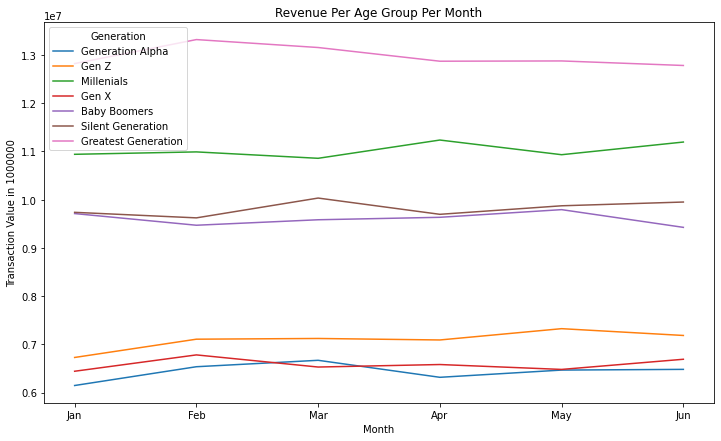

In [9]:
data= pivot_table_4.plot.line(figsize=(12,7))
data.set_xlabel("Month")
data.set_ylabel("Transaction Value in 1000000")
data.set_title("Revenue Per Age Group Per Month")

In [13]:
new_df=df.explode("transaction_items") 

def items(x):
    charset=[
        *[str(i) for i in range(10)]
    ]
    x="".join([i for i in x if i in charset])
    return int(x[-1])
                     
new_df["Amount"]= new_df["transaction_items"].apply(items)

def formating_item(a):
    formats=(a.split(",")[1])
    return (formats)

new_df["transaction_items"]= new_df["transaction_items"].apply(formating_item)

new_df["Generation"]= df["Generation"]

new_df= new_df[["name","transaction_items","Amount","transaction_value","Month", "Generation"]]
new_df

,name,transaction_items,Amount,transaction_value,Month,Generation
0,Jennifer Campbell,Beef Chicharon,4,5196,Jan,Greatest Generation
1,Melissa Kim,Beef Chicharon,3,12056,Jan,Generation Alpha
1,Melissa Kim,Nutrional Milk,4,12056,Jan,Generation Alpha
1,Melissa Kim,Orange Beans,1,12056,Jan,Generation Alpha
2,Melissa Kim,Gummy Vitamins,3,5500,Jan,Generation Alpha
...,...,...,...,...,...,...
83034,Donald Andersen,Nutrional Milk,2,4280,Jun,Greatest Generation
83034,Donald Andersen,Gummy Worms,2,4280,Jun,Greatest Generation
83035,Stephanie Russell,Nutrional Milk,1,2639,Jun,Generation Alpha
83035,Stephanie Russell,Gummy Worms,3,2639,Jun,Generation Alpha


In [14]:
pivot_table_5= pd.pivot_table(new_df,index= "transaction_items", columns= "Generation", values= "Amount", aggfunc="sum")
pivot_table_5

Generation,Generation Alpha,Gen Z,Millenials,Gen X,Baby Boomers,Silent Generation,Greatest Generation
transaction_items,,,,,,,
Beef Chicharon,5934,6642,10158,6114,9213,9133,12108
Gummy Vitamins,5984,6593,10365,6334,9083,9195,12022
Gummy Worms,6007,6675,10263,6109,8915,9287,12063
Kimchi and Seaweed,6018,6717,10601,6138,8777,9256,11883
Nutrional Milk,6019,6525,10100,6035,8789,9041,12219
Orange Beans,6194,6888,10214,6156,8838,9272,11844
Yummy Vegetables,6017,6624,10524,6007,8843,9253,12161


Text(0.5, 1.0, 'Amount of Items Purchased Per Generation')

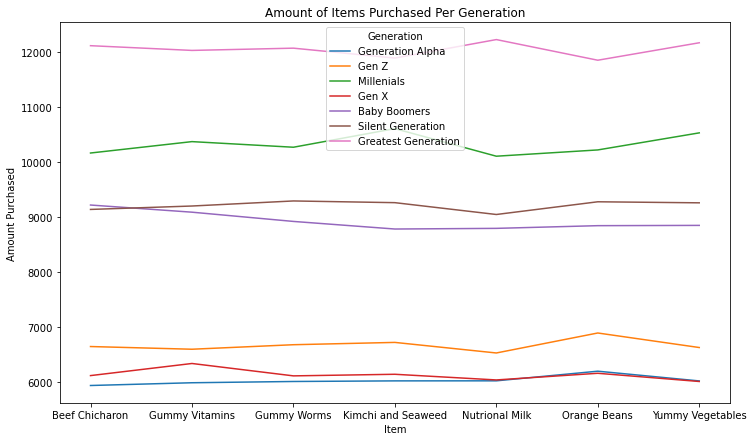

In [17]:
data= pivot_table_5.plot.line(figsize=(12,7))
data.set_xlabel("Item")
data.set_ylabel("Amount Purchased")
data.set_title("Amount of Items Purchased Per Generation")

In [11]:
pivot_table_6= pd.pivot_table(new_df,index="Month",columns="transaction_items",values="Amount",aggfunc="sum")

#Total amount of goods sold per month
pivot_table_6

transaction_items,Beef Chicharon,Gummy Vitamins,Gummy Worms,Kimchi and Seaweed,Nutrional Milk,Orange Beans,Yummy Vegetables
Month,,,,,,,
Jan,9665,9681,9559,9676,9727,9774,9959
Feb,10001,9980,9996,9949,9691,10037,10256
Mar,9816,10145,9986,9967,9876,9611,9896
Apr,9890,9842,10043,9921,9786,9914,9861
May,10028,9948,9801,9773,9881,9964,9735
Jun,9902,9980,9934,10104,9767,10106,9722


Text(0.5, 1.0, 'Amount of Each Item Purchased Per Month')

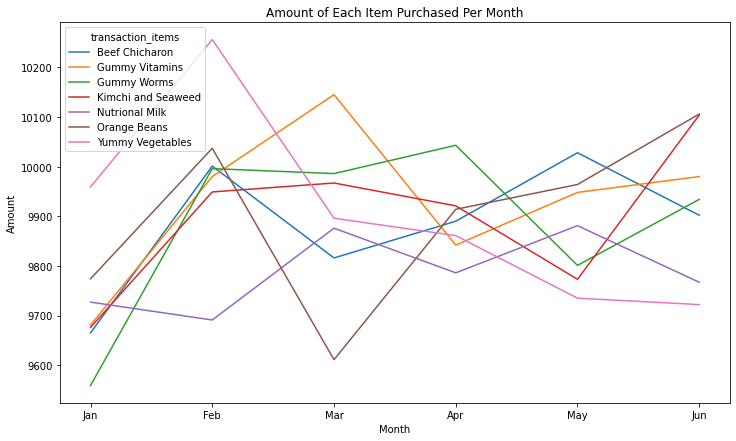

In [12]:
data= pivot_table_6.plot.line(figsize=(12,7))
data.set_xlabel("Month")
data.set_ylabel("Amount")
data.set_title("Amount of Each Item Purchased Per Month")

In [13]:
price_list_df= new_df.copy()
price_list= { "Orange Beans" : price_list_df.transaction_value.loc[price_list_df["transaction_items"]== "Orange Beans"].min(),
"Gummy Vitamins" : price_list_df.transaction_value.loc[price_list_df["transaction_items"]== "Gummy Vitamins"].min(),
"Kimchi and Seaweed" : price_list_df.transaction_value.loc[price_list_df["transaction_items"]== "Kimchi and Seaweed"].min(),
"Gummy Worms" : price_list_df.transaction_value.loc[price_list_df["transaction_items"]== "Gummy Worms"].min(),
"Yummy Vegetables" : price_list_df.transaction_value.loc[price_list_df["transaction_items"]== "Yummy Vegetables"].min(),
"Beef Chicharon" : price_list_df.transaction_value.loc[price_list_df["transaction_items"]== "Beef Chicharon"].min(),
"Nutrional Milk" : price_list_df.transaction_value.loc[price_list_df["transaction_items"]== "Nutrional Milk"].min()
}
price_list

{'Orange Beans': 199,
 'Gummy Vitamins': 1500,
 'Kimchi and Seaweed': 799,
 'Gummy Worms': 150,
 'Yummy Vegetables': 500,
 'Beef Chicharon': 1299,
 'Nutrional Milk': 1990}

In [14]:
def price(x):
    price_list= { "Orange Beans" : 199,
     "Gummy Vitamins" : 1500,
    "Kimchi and Seaweed" : 799,
     "Gummy Worms" : 150,
     "Yummy Vegetables" : 500,
     "Beef Chicharon" : 1299,
     "Nutrional Milk" : 1990
    }
    return price_list[x]

price_list_df["Price"]= new_df["transaction_items"].apply(price)

price_list_df["Item_Price"]=price_list_df["Amount"]*price_list_df["Price"]

price_list_df= price_list_df[["name","Month","transaction_items","Price","Amount","Item_Price"]]

pivot_table_7= pd.pivot_table(price_list_df,index="Month",columns="transaction_items",values="Item_Price",aggfunc="sum")

#total revenue for each good sold per month
pivot_table_7

transaction_items,Beef Chicharon,Gummy Vitamins,Gummy Worms,Kimchi and Seaweed,Nutrional Milk,Orange Beans,Yummy Vegetables
Month,,,,,,,
Jan,12554835,14521500,1433850,7731124,19356730,1945026,4979500
Feb,12991299,14970000,1499400,7949251,19285090,1997363,5128000
Mar,12750984,15217500,1497900,7963633,19653240,1912589,4948000
Apr,12847110,14763000,1506450,7926879,19474140,1972886,4930500
May,13026372,14922000,1470150,7808627,19663190,1982836,4867500
Jun,12862698,14970000,1490100,8073096,19436330,2011094,4861000


Text(0.5, 1.0, 'Revenue of Each Item Purchased Per Month')

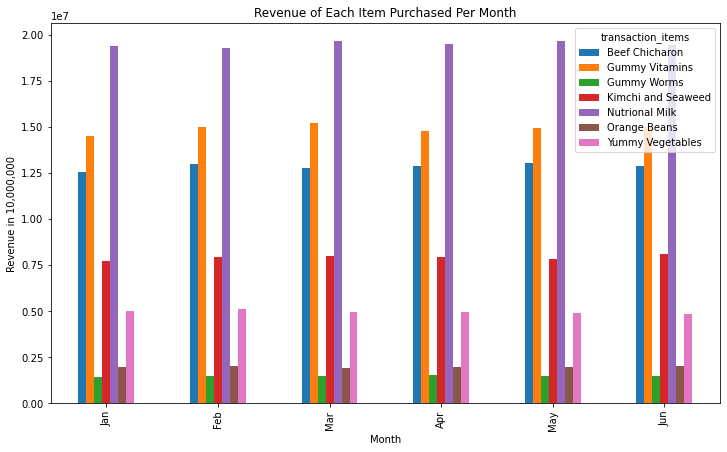

In [15]:
data= pivot_table_7.plot.bar(figsize=(12,7))
data.set_xlabel("Month")
data.set_ylabel("Revenue in 10,000,000")
data.set_title("Revenue of Each Item Purchased Per Month")

In [21]:
df["filler"]=1

pivot_dump= pd.pivot_table(df,index="name",columns="Month",values="filler",aggfunc="count", margins= True, fill_value=0)
x= pivot_dump

Repeater= { "Jan": 0, 
           "Feb": list(x.loc[(x["Jan"]>= 1)& (x["Feb"]>= 1)].count()-1)[0], 
           "Mar": list(x.loc[(x["Feb"]>= 1)& (x["Mar"]>= 1)].count()-1)[0],
           "Apr": list(x.loc[(x["Mar"]>= 1)& (x["Apr"]>= 1)].count()-1)[0], 
           "May": list(x.loc[(x["Apr"]>= 1)& (x["May"]>= 1)].count()-1)[0], 
           "Jun": list(x.loc[(x["May"]>= 1)& (x["Jun"]>= 1)].count()-1)[0] 
          }

Inactive = { "Jan": 0, 
           "Feb": list(x.loc[(x["Jan"]>= 1)& (x["Feb"]== 0)].count())[0],
           "Mar": list(x.loc[(x["Jan"]>= 0)& (x["Feb"]>= 0)& (x["Mar"]== 0)].count())[0]-list(x.loc[(x["Jan"]== 0)& (x["Feb"]== 0)& (x["Mar"]== 0)].count())[0],
           "Apr": list(x.loc[(x["Jan"]>= 0)& (x["Feb"]>= 0)& (x["Mar"]>= 0)& (x["Apr"]== 0)].count())[0]-list(x.loc[(x["Jan"]== 0)& (x["Feb"]== 0)& (x["Mar"]== 0)& (x["Apr"]== 0)].count())[0], 
           "May": list(x.loc[(x["Jan"]>= 0)& (x["Feb"]>= 0)& (x["Mar"]>= 0)& (x["Apr"]>= 0)& (x["May"]== 0)].count())[0]-list(x.loc[(x["Jan"]== 0)& (x["Feb"]== 0)& (x["Mar"]== 0)& (x["Apr"]== 0)& (x["May"]== 0)].count())[0], 
           "Jun": list(x.loc[(x["Jan"]>= 0)& (x["Feb"]>= 0)& (x["Mar"]>= 0)& (x["Apr"]>= 0)& (x["May"]>= 0)& (x["Jun"]== 0)].count())[0]-list(x.loc[(x["Jan"]== 0)& (x["Feb"]== 0)& (x["Mar"]== 0)& (x["Apr"]== 0)& (x["May"]== 0)& (x["Jun"]== 0)].count())[0] 
          }

Engaged = { "Jan": list(x.loc[(x["Jan"]>= 1)].count()-1)[0], 
           "Feb": list(x.loc[(x["Jan"]>= 1)& (x["Feb"]>= 1)].count()-1)[0],
           "Mar": list(x.loc[(x["Jan"]>= 1)& (x["Feb"]>= 1)& (x["Mar"]>= 1)].count()-1)[0],
           "Apr": list(x.loc[(x["Jan"]>= 1)& (x["Feb"]>= 1)& (x["Mar"]>= 1)& (x["Apr"]>= 1)].count()-1)[0], 
           "May": list(x.loc[(x["Jan"]>= 1)& (x["Feb"]>= 1)& (x["Mar"]>= 1)& (x["Apr"]>= 1)& (x["May"]>= 1)].count()-1)[0], 
           "Jun": list(x.loc[(x["Jan"]>= 1)& (x["Feb"]>= 1)& (x["Mar"]>= 1)& (x["Apr"]>= 1)& (x["May"]>= 1)& (x["Jun"]>= 1)].count()-1)[0] 
          }

First_Timer= { "Jan": list(x.loc[(x["Jan"]>= 1)].count()-1)[0], 
           "Feb": list(x.loc[(x["Jan"]== 0)& (x["Feb"]>= 1)].count()-1)[0],
           "Mar": list(x.loc[(x["Jan"]== 0)& (x["Feb"]== 0)& (x["Mar"]>= 1)].count()-1)[0],
           "Apr": list(x.loc[(x["Jan"]== 0)& (x["Feb"]== 0)& (x["Mar"]== 0)& (x["Apr"]>= 1)].count()-1)[0], 
           "May": list(x.loc[(x["Jan"]== 0)& (x["Feb"]== 0)& (x["Mar"]== 0)& (x["Apr"]== 0)& (x["May"]>= 1)].count()-1)[0], 
           "Jun": list(x.loc[(x["Jan"]== 0)& (x["Feb"]== 0)& (x["Mar"]== 0)& (x["Apr"]== 0)& (x["May"]== 0)& (x["Jun"]>= 1)].count()-1)[0] 
     }

details=  {
    "Repeater" : Repeater,
    "Inactive" : Inactive,
    "Engaged": Engaged,
    "First Timer": First_Timer,
}
metrics_df = pd.DataFrame(details)
metrics_df.transpose()

,Jan,Feb,Mar,Apr,May,Jun
Repeater,0,5172,5216,5154,5110,5193
Inactive,0,1416,1747,1909,1917,1835
Engaged,6588,5172,4126,3289,2667,2190
First Timer,6588,1458,321,95,19,1


Text(0.5, 1.0, 'Metrics')

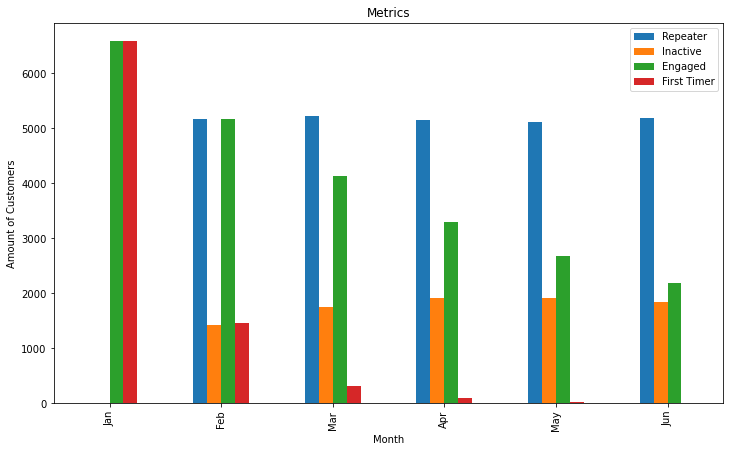

In [41]:
data= metrics_df.plot.bar(figsize=(12,7))
data.set_xlabel("Month")
data.set_ylabel("Amount of Customers")
data.set_title("Metrics")